## Lab 3
### Part 1: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print("Directory", path, "is created!")
    else:
        print("Directory", path, "already exists!")


root_path = "fmnist"
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(
    root_path, train=True, transform=train_transform, target_transform=None, download=download
)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(
    root_path, train=False, transform=test_transform, target_transform=None, download=download
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 13.1MB/s]


Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.87MB/s]


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 10.3MB/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [14]:
train_loader = torch.utils.data.DataLoader(
    fmnist_dataset_train, batch_size=128, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    fmnist_dataset_test, batch_size=256, shuffle=False, num_workers=2
)

loaders = {'train' : train_loader, 'val' : test_loader}

In [15]:
len(fmnist_dataset_test)

10000

In [20]:
for img, label in train_loader:
    print(img.shape)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


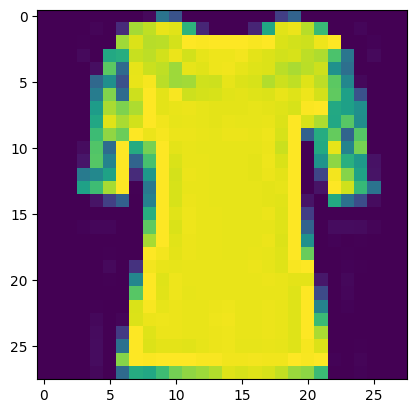

In [21]:
plt.imshow(img[3, 0].numpy())

### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [29]:
!pip install pytorch-lightning torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 31.1 MB/s eta 0:00:00


In [30]:
import torch
from torch import nn
import pytorch_lightning as pl
from torchmetrics.functional import accuracy

In [38]:
class TinyNeuralNetwork(pl.LightningModule):
    def __init__(self, input_shape=28 * 28, num_classes=10, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()
        act = nn.ReLU()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 256),
            nn.BatchNorm1d(256),
            act,
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            act,
            nn.Dropout(0.3),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            act,
            nn.Dropout(0.25),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            act,
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            act,
            nn.Dropout(0.2),
            nn.Linear(32, num_classes)
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss_fn(logits, y)
        acc = accuracy(torch.argmax(logits, dim=1), y, task="multiclass", num_classes=self.hparams.num_classes)
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss_fn(logits, y)
        acc = accuracy(torch.argmax(logits, dim=1), y, task="multiclass", num_classes=self.hparams.num_classes)
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
        return [optimizer], [scheduler]

In [39]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
       BatchNorm1d-3                  [-1, 256]             512
              ReLU-4                  [-1, 256]               0
           Dropout-5                  [-1, 256]               0
            Linear-6                  [-1, 128]          32,896
       BatchNorm1d-7                  [-1, 128]             256
              ReLU-8                  [-1, 128]               0
           Dropout-9                  [-1, 128]               0
           Linear-10                  [-1, 128]          16,512
      BatchNorm1d-11                  [-1, 128]             256
             ReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]               0
           Linear-14                   

Your experiments come here:

In [40]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [46]:
# Коллбэки
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",
    mode="max",
    save_top_k=1,
    verbose=True
)
early_stopping_callback = EarlyStopping(monitor="val_acc", patience=10, mode="max")

# Инициализация модели
model = TinyNeuralNetwork(input_shape=28 * 28, num_classes=10, lr=1e-4)

# Инициализация Trainer
trainer = pl.Trainer(
    max_epochs=120,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1 if torch.cuda.is_available() else None,
    callbacks=[checkpoint_callback]
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [47]:
trainer.fit(model, train_dataloaders=loaders['train'], val_dataloaders=loaders['val'])

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 262 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
262 K     Trainable params
0         Non-trainable params
262 K     Total params
1.049     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 469: 'val_acc' reached 0.78020 (best 0.78020), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=0-step=469.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 938: 'val_acc' reached 0.82810 (best 0.82810), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=1-step=938.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1407: 'val_acc' reached 0.83920 (best 0.83920), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=2-step=1407.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1876: 'val_acc' reached 0.85240 (best 0.85240), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=3-step=1876.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 2345: 'val_acc' reached 0.85800 (best 0.85800), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=4-step=2345.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 2814: 'val_acc' reached 0.86300 (best 0.86300), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=5-step=2814.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 3283: 'val_acc' reached 0.86820 (best 0.86820), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=6-step=3283.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 3752: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 4221: 'val_acc' reached 0.87390 (best 0.87390), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=8-step=4221.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 4690: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 5159: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 5628: 'val_acc' reached 0.87550 (best 0.87550), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=11-step=5628.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 6097: 'val_acc' reached 0.87970 (best 0.87970), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=12-step=6097.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 6566: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 7035: 'val_acc' reached 0.88010 (best 0.88010), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=14-step=7035.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 7504: 'val_acc' reached 0.88160 (best 0.88160), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=15-step=7504.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 7973: 'val_acc' reached 0.88170 (best 0.88170), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=16-step=7973.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 8442: 'val_acc' reached 0.88280 (best 0.88280), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=17-step=8442.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 8911: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 9380: 'val_acc' reached 0.88630 (best 0.88630), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=19-step=9380.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 9849: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 10318: 'val_acc' reached 0.89020 (best 0.89020), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=21-step=10318.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 10787: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 11256: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 11725: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 12194: 'val_acc' reached 0.89100 (best 0.89100), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=25-step=12194.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 12663: 'val_acc' reached 0.89310 (best 0.89310), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=26-step=12663.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 13132: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 13601: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 14070: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 14539: 'val_acc' reached 0.89330 (best 0.89330), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=30-step=14539.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 15008: 'val_acc' reached 0.89560 (best 0.89560), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=31-step=15008.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 15477: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 15946: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 16415: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 16884: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 17353: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 17822: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 38, global step 18291: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 18760: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 40, global step 19229: 'val_acc' reached 0.89620 (best 0.89620), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=40-step=19229.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 41, global step 19698: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 42, global step 20167: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 43, global step 20636: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 44, global step 21105: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 45, global step 21574: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 46, global step 22043: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 47, global step 22512: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 48, global step 22981: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 49, global step 23450: 'val_acc' reached 0.89660 (best 0.89660), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=49-step=23450.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 50, global step 23919: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 51, global step 24388: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 52, global step 24857: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 53, global step 25326: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 54, global step 25795: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 55, global step 26264: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 56, global step 26733: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 57, global step 27202: 'val_acc' reached 0.89720 (best 0.89720), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=57-step=27202.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 58, global step 27671: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 59, global step 28140: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 60, global step 28609: 'val_acc' reached 0.89800 (best 0.89800), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=60-step=28609.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 61, global step 29078: 'val_acc' reached 0.89850 (best 0.89850), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=61-step=29078.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 62, global step 29547: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 63, global step 30016: 'val_acc' reached 0.89930 (best 0.89930), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=63-step=30016.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 64, global step 30485: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 65, global step 30954: 'val_acc' reached 0.89960 (best 0.89960), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=65-step=30954.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 66, global step 31423: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 67, global step 31892: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 68, global step 32361: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 69, global step 32830: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 70, global step 33299: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 71, global step 33768: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 72, global step 34237: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 73, global step 34706: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 74, global step 35175: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 75, global step 35644: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 76, global step 36113: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 77, global step 36582: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 78, global step 37051: 'val_acc' reached 0.89970 (best 0.89970), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=78-step=37051.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 79, global step 37520: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 80, global step 37989: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 81, global step 38458: 'val_acc' reached 0.90050 (best 0.90050), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=81-step=38458.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 82, global step 38927: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 83, global step 39396: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 84, global step 39865: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 85, global step 40334: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 86, global step 40803: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 87, global step 41272: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 88, global step 41741: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 89, global step 42210: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 90, global step 42679: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 91, global step 43148: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 92, global step 43617: 'val_acc' reached 0.90190 (best 0.90190), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=92-step=43617.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 93, global step 44086: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 94, global step 44555: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 95, global step 45024: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 96, global step 45493: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 97, global step 45962: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 98, global step 46431: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 99, global step 46900: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 100, global step 47369: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 101, global step 47838: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 102, global step 48307: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 103, global step 48776: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 104, global step 49245: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 105, global step 49714: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 106, global step 50183: 'val_acc' reached 0.90230 (best 0.90230), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=106-step=50183.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 107, global step 50652: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 108, global step 51121: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 109, global step 51590: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 110, global step 52059: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 111, global step 52528: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 112, global step 52997: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 113, global step 53466: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 114, global step 53935: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 115, global step 54404: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 116, global step 54873: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 117, global step 55342: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 118, global step 55811: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 119, global step 56280: 'val_acc' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=120` reached.


In [48]:
# Получение пути к лучшей модели
best_model_path = checkpoint_callback.best_model_path
print(f"Best model saved at {best_model_path}")

# Загружаем лучшую модель
best_model = TinyNeuralNetwork.load_from_checkpoint(best_model_path)

Best model saved at /content/lightning_logs/version_2/checkpoints/epoch=106-step=50183.ckpt


In [51]:
best_val_acc = trainer.callback_metrics["val_acc"].item()
print(f"Best validation accuracy: {best_val_acc:.4f}")

Best validation accuracy: 0.8989


In [71]:
# Интерактивный просмотр логов
#%reload_ext tensorboard
#%tensorboard --logdir=lightning_logs/

**Выводы:**

Используя PyTorch Lightning, я смог достичь требуемого результата с лучшим **validation accuracy** равным **0.8989**.

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [52]:
class OverfittingNeuralNetwork(pl.LightningModule):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(OverfittingNeuralNetwork, self).__init__()
        act = nn.LeakyReLU()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 2048),
            act,

            nn.Linear(2048, 2048),
            act,

            nn.Linear(2048, 1024),
            act,

            nn.Linear(1024, 512),
            act,

            nn.Linear(512, 256),
            act,

            nn.Linear(256, 128),
            act,

            nn.Linear(128, 64),
            act,

            nn.Linear(64, num_classes)
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = accuracy(torch.argmax(logits, dim=1), y, task="multiclass", num_classes=10)
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = accuracy(torch.argmax(logits, dim=1), y, task="multiclass", num_classes=10)
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = accuracy(torch.argmax(logits, dim=1), y, task="multiclass", num_classes=10)
        self.log("test_loss", loss, on_step=False, on_epoch=True)
        self.log("test_acc", acc, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=5e-4)
        return optimizer

In [53]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 2048]       1,607,680
         LeakyReLU-3                 [-1, 2048]               0
            Linear-4                 [-1, 2048]       4,196,352
         LeakyReLU-5                 [-1, 2048]               0
            Linear-6                 [-1, 1024]       2,098,176
         LeakyReLU-7                 [-1, 1024]               0
            Linear-8                  [-1, 512]         524,800
         LeakyReLU-9                  [-1, 512]               0
           Linear-10                  [-1, 256]         131,328
        LeakyReLU-11                  [-1, 256]               0
           Linear-12                  [-1, 128]          32,896
        LeakyReLU-13                  [-1, 128]               0
           Linear-14                   

In [54]:
from torch.utils.data import Subset

sub_len = len(fmnist_dataset_train) // 2
sub_indxs = torch.randperm(len(fmnist_dataset_train))[:sub_len]
sub_train = Subset(fmnist_dataset_train, sub_indxs)

small_train_loader = torch.utils.data.DataLoader(sub_train,
                                                 batch_size=128,
                                                 shuffle=True,
                                                 num_workers=2)

test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

small_loaders = {'train': small_train_loader,
                 'val': test_loader}

In [55]:
# Коллбэк для сохранения лучшей модели
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",
    mode="max",
    save_top_k=1,
    verbose=True
)

# Инициализация модели
model = OverfittingNeuralNetwork()

# Инициализация тренера
trainer = pl.Trainer(
    max_epochs=60,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1 if torch.cuda.is_available() else None,
    callbacks=[checkpoint_callback]
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [56]:
trainer.fit(model, train_dataloaders=small_train_loader, val_dataloaders=test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 8.6 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
8.6 M     Trainable params
0         Non-trainable params
8.6 M     Total params
34.401    Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 235: 'val_acc' reached 0.77140 (best 0.77140), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=0-step=235.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 470: 'val_acc' reached 0.80660 (best 0.80660), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=1-step=470.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 705: 'val_acc' reached 0.81490 (best 0.81490), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=2-step=705.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 940: 'val_acc' reached 0.84830 (best 0.84830), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=3-step=940.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1175: 'val_acc' reached 0.85810 (best 0.85810), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=4-step=1175.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 1410: 'val_acc' reached 0.86090 (best 0.86090), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=5-step=1410.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 1645: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 1880: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 2115: 'val_acc' reached 0.86500 (best 0.86500), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=8-step=2115.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 2350: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 2585: 'val_acc' reached 0.86950 (best 0.86950), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=10-step=2585.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 2820: 'val_acc' reached 0.87360 (best 0.87360), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=11-step=2820.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 3055: 'val_acc' reached 0.87950 (best 0.87950), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=12-step=3055.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 3290: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 3525: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 3760: 'val_acc' reached 0.88100 (best 0.88100), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=15-step=3760.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 3995: 'val_acc' reached 0.88120 (best 0.88120), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=16-step=3995.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 4230: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 4465: 'val_acc' reached 0.88310 (best 0.88310), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=18-step=4465.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 4700: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 4935: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 5170: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 5405: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 5640: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 5875: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 6110: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 6345: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 6580: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 6815: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 7050: 'val_acc' reached 0.88330 (best 0.88330), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=29-step=7050.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 7285: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 7520: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 7755: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 7990: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 8225: 'val_acc' reached 0.88480 (best 0.88480), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=34-step=8225.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 8460: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 8695: 'val_acc' reached 0.88560 (best 0.88560), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=36-step=8695.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 8930: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 38, global step 9165: 'val_acc' reached 0.89040 (best 0.89040), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=38-step=9165.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 9400: 'val_acc' reached 0.89100 (best 0.89100), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=39-step=9400.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 40, global step 9635: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 41, global step 9870: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 42, global step 10105: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 43, global step 10340: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 44, global step 10575: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 45, global step 10810: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 46, global step 11045: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 47, global step 11280: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 48, global step 11515: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 49, global step 11750: 'val_acc' reached 0.89310 (best 0.89310), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=49-step=11750.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 50, global step 11985: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 51, global step 12220: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 52, global step 12455: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 53, global step 12690: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 54, global step 12925: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 55, global step 13160: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 56, global step 13395: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 57, global step 13630: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 58, global step 13865: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 59, global step 14100: 'val_acc' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=60` reached.


In [59]:
best_model_path = checkpoint_callback.best_model_path
print(f"Best model saved at {best_model_path}")

best_model = OverfittingNeuralNetwork.load_from_checkpoint(best_model_path)

Best model saved at /content/lightning_logs/version_3/checkpoints/epoch=49-step=11750.ckpt


In [60]:
best_val_acc = trainer.callback_metrics["val_acc"].item()
print(f"Best validation accuracy: {best_val_acc:.4f}")

Best validation accuracy: 0.8813


In [70]:
# Интерактивный просмотр логов
#%reload_ext tensorboard
#%tensorboard --logdir=lightning_logs/

**Выводы:**

Наблюдается, что, несмотря на снижение лосса на тренировочной выборке на протяжении всего обучения, на тестовой выборке лосс начинает расти уже после 10-й эпохи и к концу обучения становится даже выше начального значения, что является явным признаком переобучения.

Кроме того, видно, что точность на тесте после 10-й эпохи практически не изменяется (за исключением небольших колебаний). Это не так плохо, поскольку точность могла бы начать снижаться.

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [62]:
class FixedNeuralNetwork(pl.LightningModule):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(FixedNeuralNetwork, self).__init__()
        act = nn.LeakyReLU()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 2048),
            act,
            nn.BatchNorm1d(2048),
            nn.Dropout(0.8),

            nn.Linear(2048, 2048),
            act,
            nn.BatchNorm1d(2048),
            nn.Dropout(0.8),

            nn.Linear(2048, 1024),
            act,
            nn.BatchNorm1d(1024),
            nn.Dropout(0.6),

            nn.Linear(1024, 512),
            act,
            nn.BatchNorm1d(512),
            nn.Dropout(0.6),

            nn.Linear(512, 256),
            act,
            nn.BatchNorm1d(256),
            nn.Dropout(0.6),

            nn.Linear(256, 128),
            act,
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),

            nn.Linear(128, 64),
            act,
            nn.BatchNorm1d(64),
            nn.Dropout(0.4),

            nn.Linear(64, num_classes)
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = accuracy(torch.argmax(logits, dim=1), y, task="multiclass", num_classes=10)
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = accuracy(torch.argmax(logits, dim=1), y, task="multiclass", num_classes=10)
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = accuracy(torch.argmax(logits, dim=1), y, task="multiclass", num_classes=10)
        self.log("test_loss", loss, on_step=False, on_epoch=True)
        self.log("test_acc", acc, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=5e-4)
        return optimizer

In [63]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 2048]       1,607,680
         LeakyReLU-3                 [-1, 2048]               0
       BatchNorm1d-4                 [-1, 2048]           4,096
           Dropout-5                 [-1, 2048]               0
            Linear-6                 [-1, 2048]       4,196,352
         LeakyReLU-7                 [-1, 2048]               0
       BatchNorm1d-8                 [-1, 2048]           4,096
           Dropout-9                 [-1, 2048]               0
           Linear-10                 [-1, 1024]       2,098,176
        LeakyReLU-11                 [-1, 1024]               0
      BatchNorm1d-12                 [-1, 1024]           2,048
          Dropout-13                 [-1, 1024]               0
           Linear-14                  [

In [64]:
# Коллбэк для сохранения лучшей модели
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",
    mode="max",
    save_top_k=1,
    verbose=True
)

# Инициализация модели
model = FixedNeuralNetwork()

# Инициализация тренера
trainer = pl.Trainer(
    max_epochs=60,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1 if torch.cuda.is_available() else None,
    callbacks=[checkpoint_callback]
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [65]:
trainer.fit(model, train_dataloaders=small_train_loader, val_dataloaders=test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 8.6 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
8.6 M     Trainable params
0         Non-trainable params
8.6 M     Total params
34.449    Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 235: 'val_acc' reached 0.60670 (best 0.60670), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=0-step=235.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 470: 'val_acc' reached 0.69580 (best 0.69580), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=1-step=470.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 705: 'val_acc' reached 0.75740 (best 0.75740), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=2-step=705.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 940: 'val_acc' reached 0.77320 (best 0.77320), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=3-step=940.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1175: 'val_acc' reached 0.78790 (best 0.78790), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=4-step=1175.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 1410: 'val_acc' reached 0.80520 (best 0.80520), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=5-step=1410.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 1645: 'val_acc' reached 0.81770 (best 0.81770), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=6-step=1645.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 1880: 'val_acc' reached 0.82660 (best 0.82660), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=7-step=1880.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 2115: 'val_acc' reached 0.83350 (best 0.83350), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=8-step=2115.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 2350: 'val_acc' reached 0.83530 (best 0.83530), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=9-step=2350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 2585: 'val_acc' reached 0.84000 (best 0.84000), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=10-step=2585.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 2820: 'val_acc' reached 0.84440 (best 0.84440), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=11-step=2820.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 3055: 'val_acc' reached 0.84770 (best 0.84770), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=12-step=3055.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 3290: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 3525: 'val_acc' reached 0.84850 (best 0.84850), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=14-step=3525.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 3760: 'val_acc' reached 0.85000 (best 0.85000), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=15-step=3760.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 3995: 'val_acc' reached 0.85260 (best 0.85260), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=16-step=3995.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 4230: 'val_acc' reached 0.85440 (best 0.85440), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=17-step=4230.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 4465: 'val_acc' reached 0.85610 (best 0.85610), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=18-step=4465.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 4700: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 4935: 'val_acc' reached 0.85730 (best 0.85730), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=20-step=4935.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 5170: 'val_acc' reached 0.85820 (best 0.85820), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=21-step=5170.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 5405: 'val_acc' reached 0.85830 (best 0.85830), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=22-step=5405.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 5640: 'val_acc' reached 0.85850 (best 0.85850), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=23-step=5640.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 5875: 'val_acc' reached 0.86260 (best 0.86260), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=24-step=5875.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 6110: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 6345: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 6580: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 6815: 'val_acc' reached 0.86360 (best 0.86360), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=28-step=6815.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 7050: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 7285: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 7520: 'val_acc' reached 0.86690 (best 0.86690), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=31-step=7520.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 7755: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 7990: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 8225: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 8460: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 8695: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 8930: 'val_acc' reached 0.86760 (best 0.86760), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=37-step=8930.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 38, global step 9165: 'val_acc' reached 0.86830 (best 0.86830), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=38-step=9165.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 9400: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 40, global step 9635: 'val_acc' reached 0.86980 (best 0.86980), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=40-step=9635.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 41, global step 9870: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 42, global step 10105: 'val_acc' reached 0.87000 (best 0.87000), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=42-step=10105.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 43, global step 10340: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 44, global step 10575: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 45, global step 10810: 'val_acc' reached 0.87130 (best 0.87130), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=45-step=10810.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 46, global step 11045: 'val_acc' reached 0.87260 (best 0.87260), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=46-step=11045.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 47, global step 11280: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 48, global step 11515: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 49, global step 11750: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 50, global step 11985: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 51, global step 12220: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 52, global step 12455: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 53, global step 12690: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 54, global step 12925: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 55, global step 13160: 'val_acc' reached 0.87350 (best 0.87350), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=55-step=13160.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 56, global step 13395: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 57, global step 13630: 'val_acc' reached 0.87390 (best 0.87390), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=57-step=13630.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 58, global step 13865: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 59, global step 14100: 'val_acc' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=60` reached.


In [66]:
best_model_path = checkpoint_callback.best_model_path
print(f"Best model saved at {best_model_path}")

best_model = FixedNeuralNetwork.load_from_checkpoint(best_model_path)

Best model saved at /content/lightning_logs/version_4/checkpoints/epoch=57-step=13630.ckpt


In [67]:
best_val_acc = trainer.callback_metrics["val_acc"].item()
print(f"Best validation accuracy: {best_val_acc:.4f}")

Best validation accuracy: 0.8735


In [69]:
# Интерактивный просмотр логов
#%reload_ext tensorboard
#%tensorboard --logdir=lightning_logs/

### Conclusions:
_Write down small report with your conclusions and your ideas._

После добавления батчнормов и дропаутов переобучение, похоже, было устранено: лосс падает как на тренировочной, так и на тестовой выборке, а точность растёт. При этом на 60-й эпохе она продолжает улучшаться. Если продолжить обучение, можно достичь ещё большей точности, чего не удавалось добиться на переобученной модели.

Также, в отличие от переобученной модели, где точность была нестабильной и колебалась от эпохи к эпохе, здесь всё стабильно, и точность растёт плавно.

**Комментарий:**

Поскольку я использовал PyTorch Lightning, интерактивные TensorBoard логи занимают достаточно много места. Поэтому ниже прилагаю скриншоты графиков лосса.

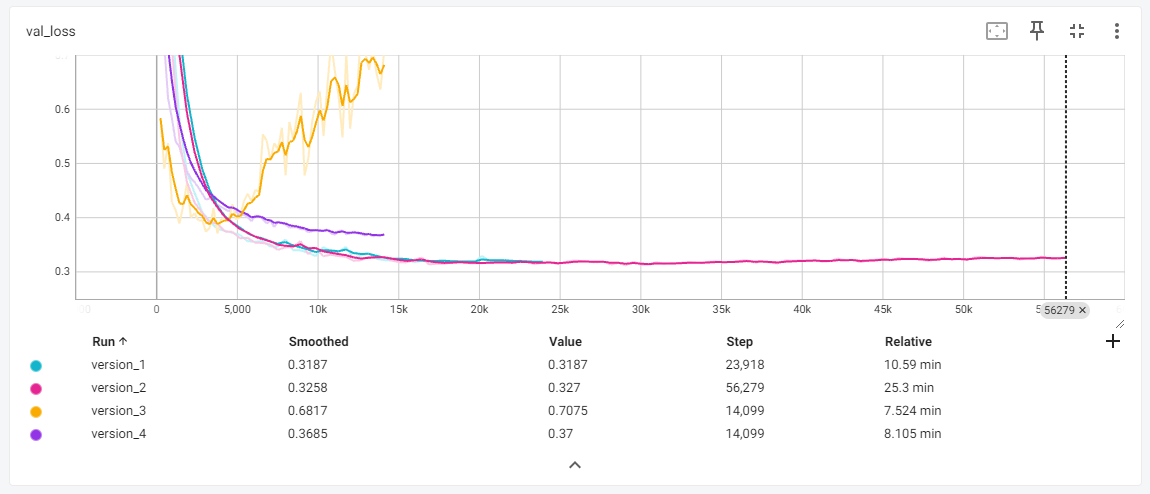

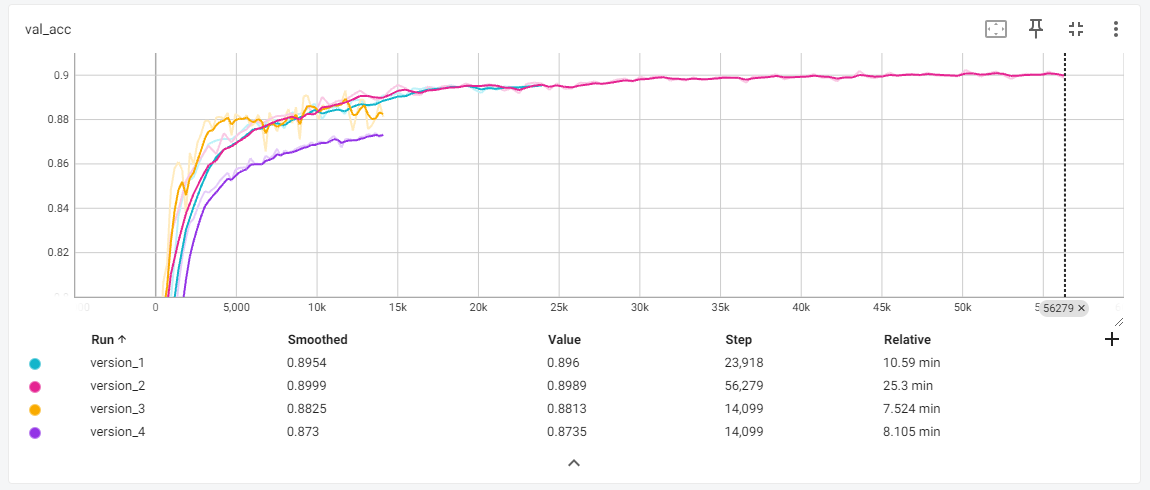

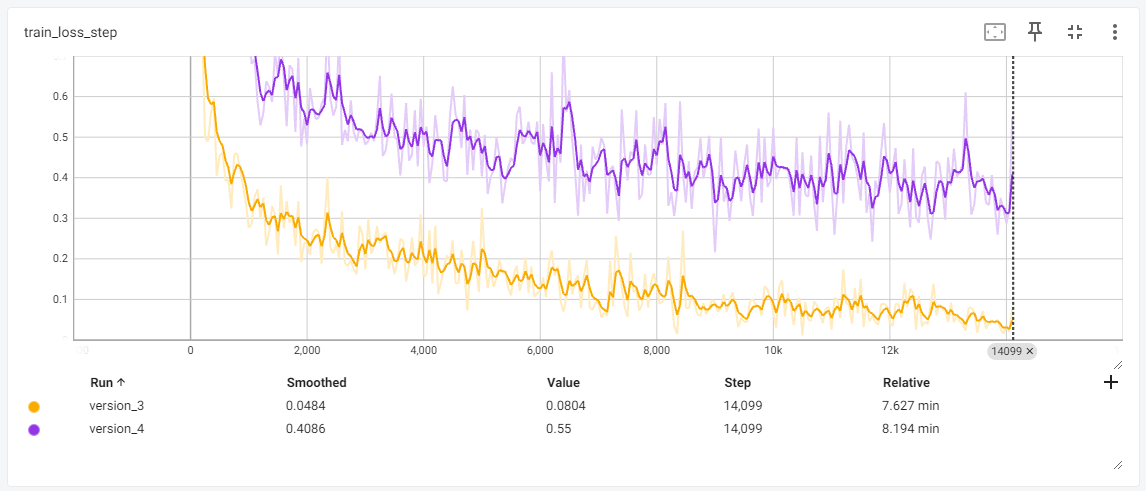

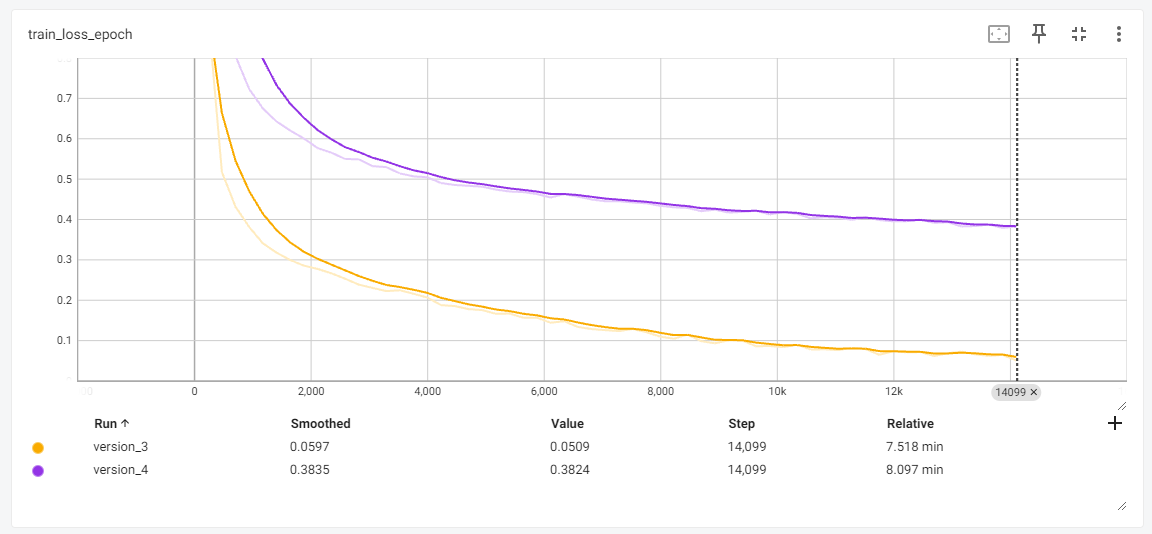

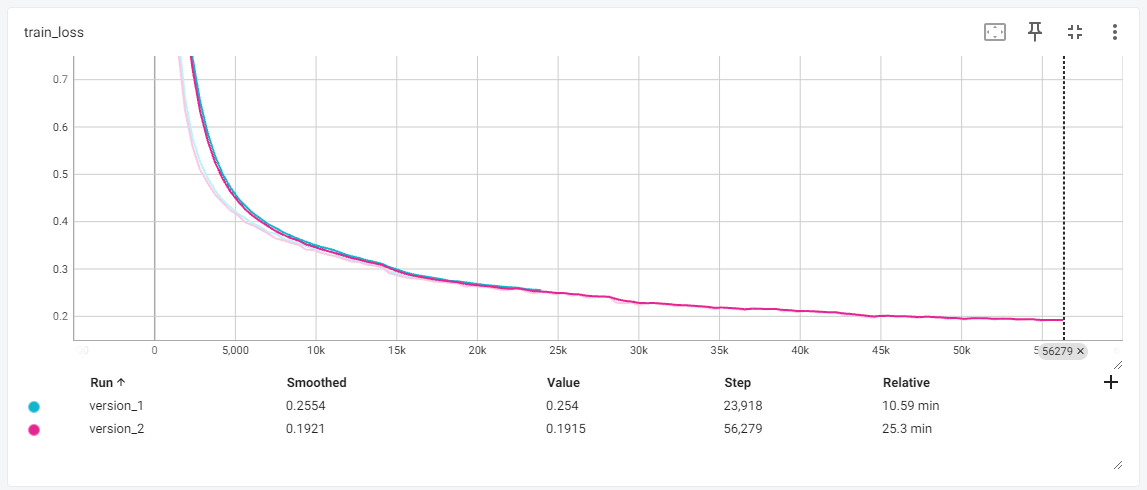

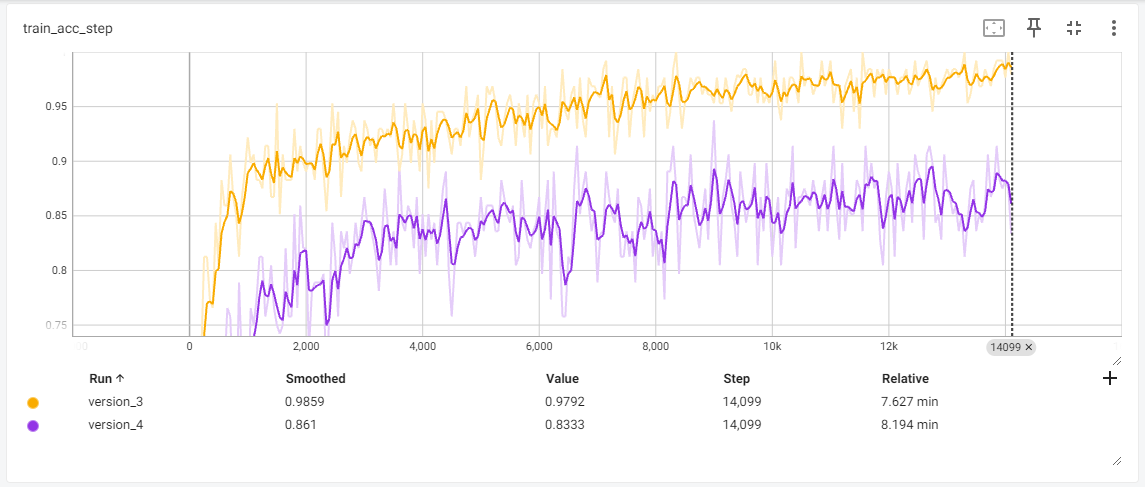

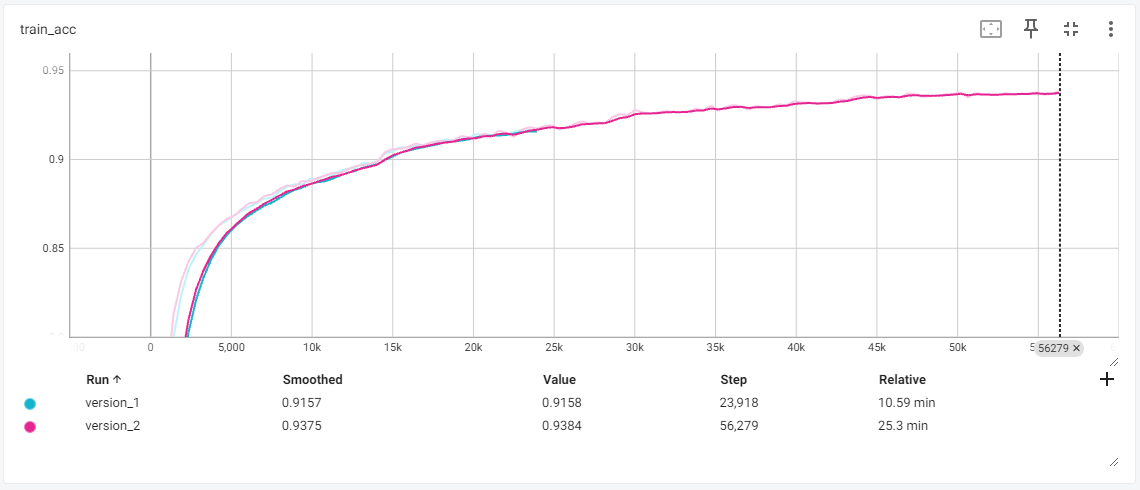